In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm


/tmp/ipykernel_1362460/3098389476.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('style.mcstyle')

In [4]:
from tools.catalog import Catalog
from tools.plot_tools import binned_plot
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# Andrea Flagship 2 data (old)

In [9]:
data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,
                   skipinitialspace=True)
data = pd.DataFrame(data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

/var/folders/_t/p68l7m6933b26j8g9wkcgq080000gp/T/ipykernel_13409/851058082.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,


In [10]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [7]:
def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    vname,
    fHa_min,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # mask out high velocity, low fHa data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)

    # get data
    data_names = ['x','y',vname]
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values

    # make train/test splits
    fold = 0
    mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    np.save(join(dirpath, f'x_train.npy'), gals[mask])
    np.save(join(dirpath, f'x_test.npy'), gals[~mask])
    np.save(join(dirpath, f'theta_train.npy'), thetas[mask])
    np.save(join(dirpath, f'theta_test.npy'), thetas[~mask])

    np.save(join(dirpath, f'ids_train.npy'), ids[mask])
    np.save(join(dirpath, f'ids_test.npy'), ids[~mask])
    np.save(join(dirpath, f'folds.npy'), folds)

    mask = folddict[ids_batch].values != fold
    np.save(join(dirpath, f'x_batch_train.npy'), x_batch[mask])
    np.save(join(dirpath, f'x_batch_test.npy'), x_batch[~mask])
    np.save(join(dirpath, f'x_sum_train.npy'), x_sum[mask])
    np.save(join(dirpath, f'x_sum_test.npy'), x_sum[~mask])
    np.save(join(dirpath, f'theta_batch_train.npy'), thetas_batch[mask])
    np.save(join(dirpath, f'theta_batch_test.npy'), thetas_batch[~mask])

    return gals, thetas, x_batch, x_sum, thetas_batch


In [8]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC50',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC50',
)
print(gals.shape)

(24120, 3)


In [9]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC100',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC100',
)
print(gals.shape)

(24452, 3)


In [10]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC50',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC50',
)
print(gals.shape)

(127937, 3)


In [11]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC100',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC100',
)
print(gals.shape)

(128066, 3)


In [16]:
print('gals.shape:', gals.shape)
print('thetas.shape:', thetas.shape)
print('x_batch.shape:', x_batch.shape)
print('x_sum.shape:', x_sum.shape)
print('thetas_batch.shape:', thetas_batch.shape)

print(f'thetas: {thetas.min()} - {thetas.max()}')

gals.shape: (128066, 3)
thetas.shape: (128066, 1)
x_batch.shape: (1000,)
x_sum.shape: (1000, 19)
thetas_batch.shape: (1000, 1)
thetas: 13.93499306319521 - 14.79519850915429


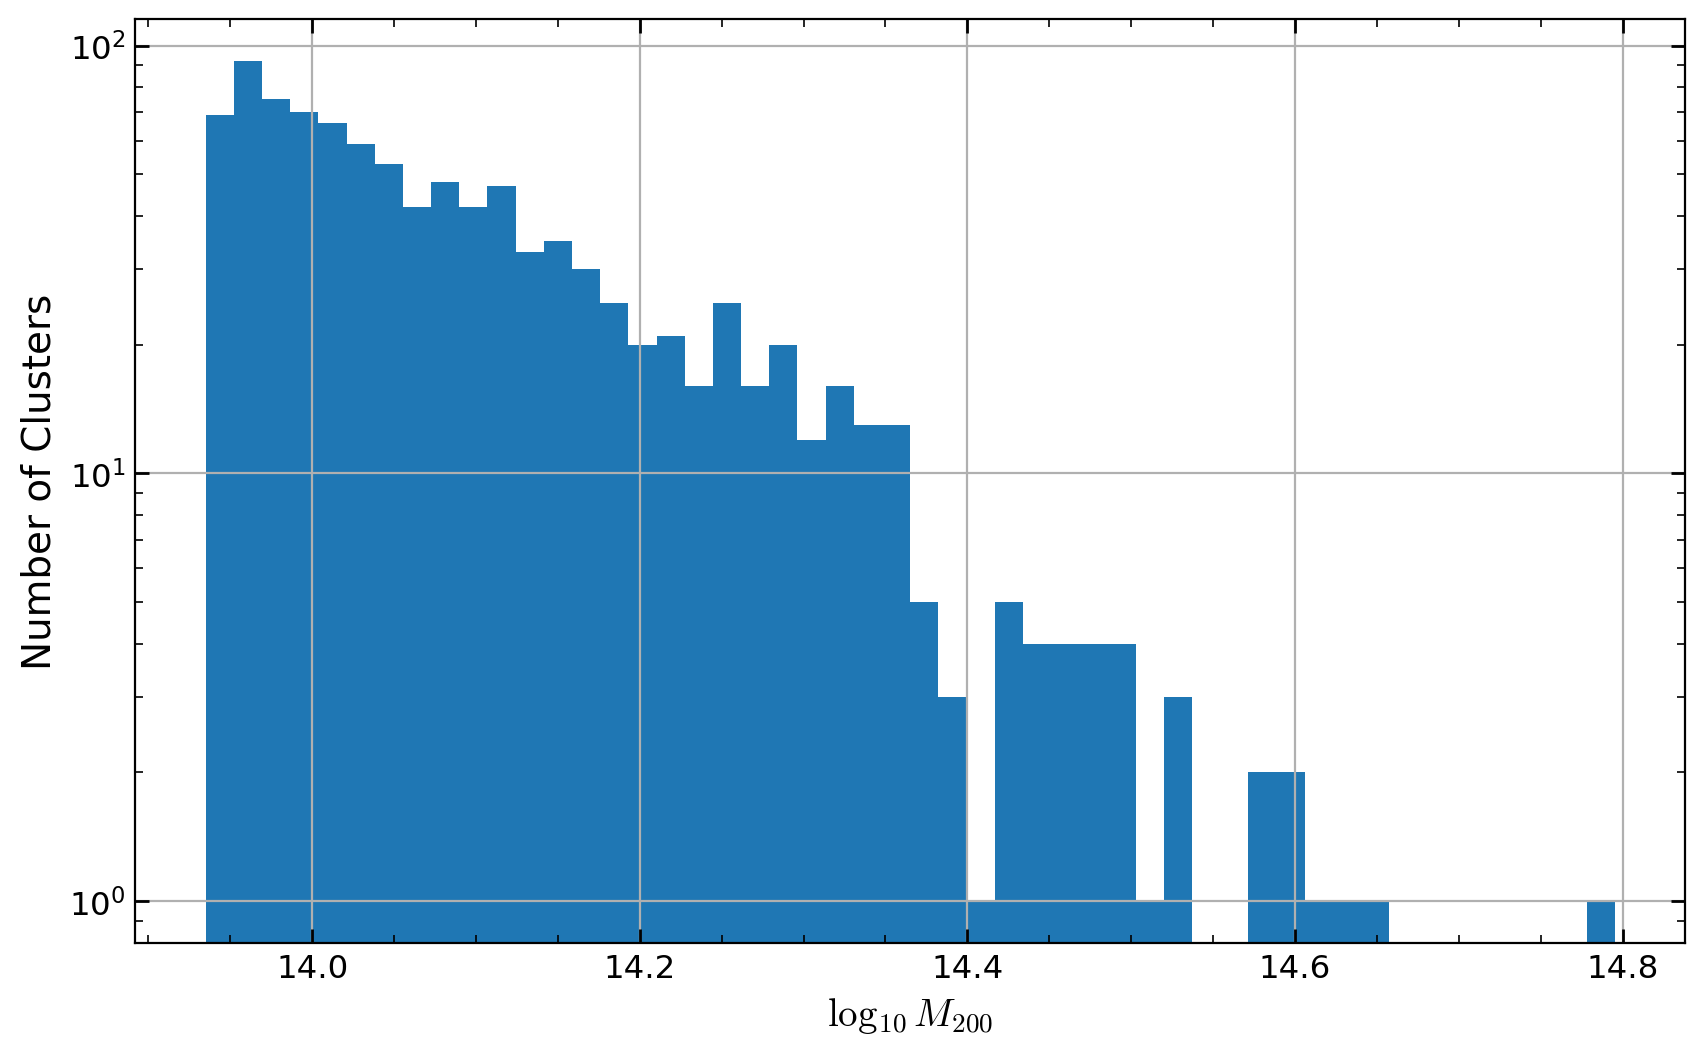

In [13]:
# plot theta distribution
plt.semilogy()
plt.hist(thetas_batch, bins=50)
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel('Number of Clusters');

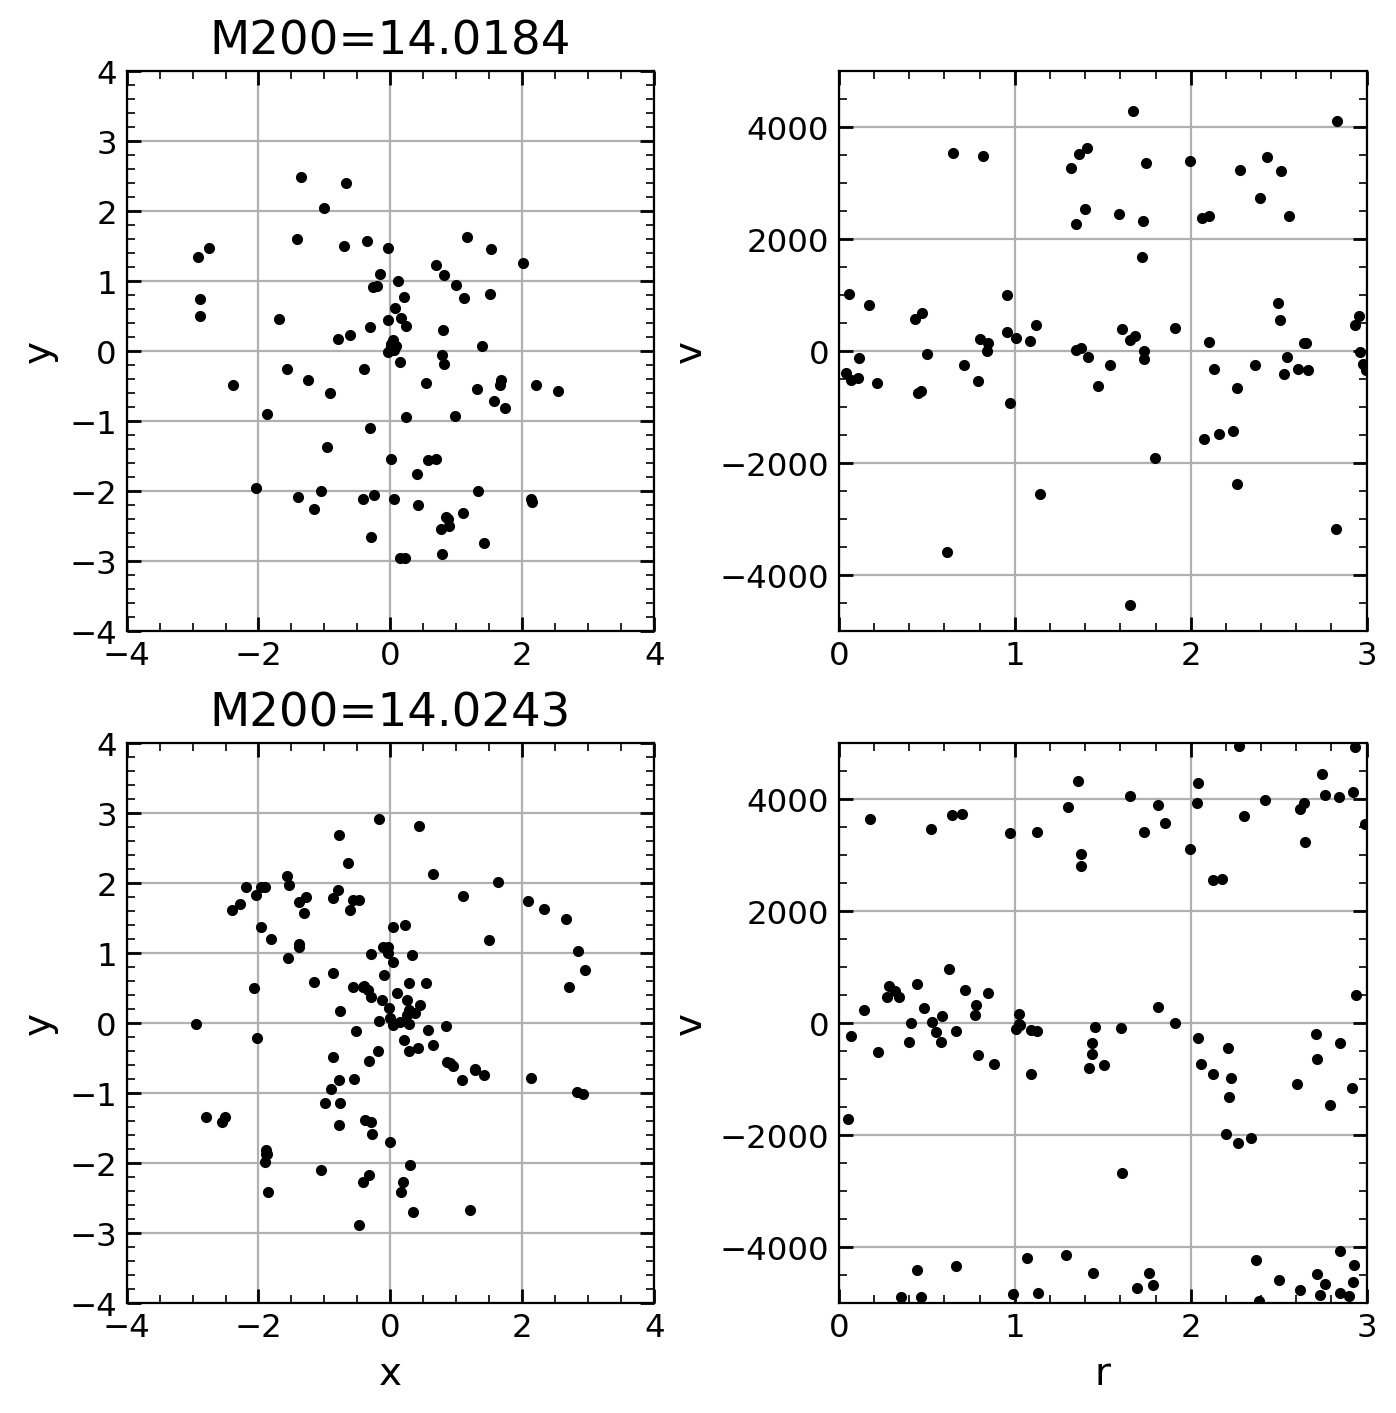

In [14]:
# plot example data
Nex = 2
f, axs = plt.subplots(Nex, 2, figsize=(8,4*Nex),
                      gridspec_kw={'wspace':0.35})
for i in range(Nex):
    ind = np.random.choice(len(x_batch))
    x = x_batch[ind]
    axs[i,0].plot(x[:,0], x[:,1], 'k.')
    axs[i,0].set_ylabel('y')
    axs[i,0].set_xlim(-4,4)
    axs[i,0].set_ylim(-4,4)
    axs[i,0].set_title(f'M200={thetas_batch[ind,0]:.4f}')
    if i==Nex-1:
        axs[i,0].set_xlabel('x')

    axs[i,1].plot(np.sqrt(x[:,0]**2 + x[:,1]**2), x[:,2], 'k.')
    axs[i,1].set_ylabel('v')
    axs[i,1].set_xlim(0,3)
    axs[i,1].set_ylim(-5000,5000)
    if i==Nex-1:
        axs[i,1].set_xlabel('r')
    

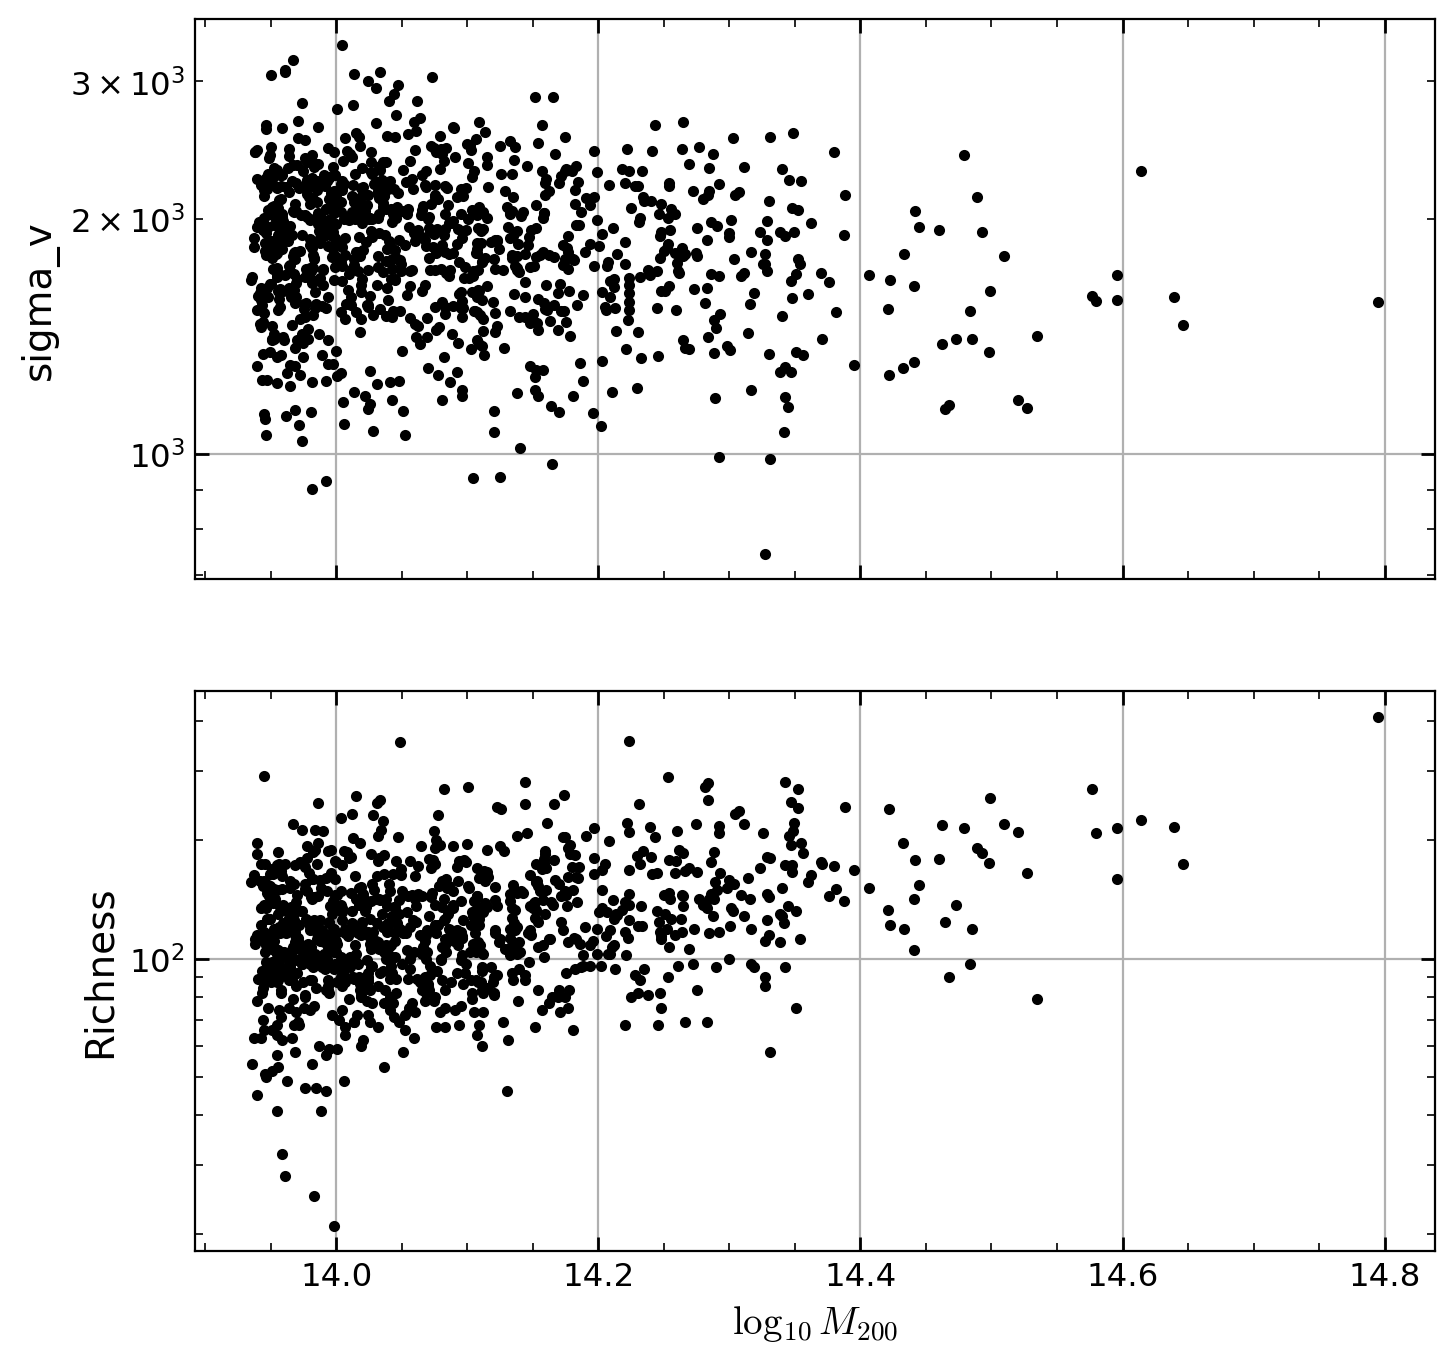

In [15]:
# plot summary relation
f, axs = plt.subplots(2, 1, figsize=(8,8), sharex=True)
axs[0].semilogy()
axs[0].plot(thetas_batch, x_sum[:,8], 'k.')
# axs[0].set_xlabel(r'$\log_{10} M_{200}$')
axs[0].set_ylabel('sigma_v');

axs[1].semilogy()
axs[1].plot(thetas_batch, x_sum[:,-1], 'k.')
axs[1].set_xlabel(r'$\log_{10} M_{200}$')
axs[1].set_ylabel('Richness');

# Andrea Flagship 2 + AMICO (01/02/2024)

In [14]:
data = pd.read_csv(
    'data/raw/deep_all_28052023.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

Ngal, Nclu = len(data), len(data.Cl_id.unique())
print(f'Ngal: {Ngal}, Nclu: {Nclu}')
print(f'Ngal/Nclu: {Ngal/Nclu:.2f}')

data.head()

/tmp/ipykernel_1362460/1982911910.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


Ngal: 273665, Nclu: 1000
Ngal/Nclu: 273.67


,x,y,zobs,zwerr,Hmag,fHa,M,C,Cl_id,xcl,ycl,ztrue,zcphot,zwC50,zwC100,zdC50,zdC100,M200,r200
0,1.696,1.214,1.007227,1.0077,22.34,-16.156,0.0,0.03,0.0,0.0,0.05,0.925311,0.977,0.923338,1.00122,1.00165,1.0021,118790000000000.0,0.73
1,1.891,-0.754,1.002224,1.0013,20.55,-15.678,0.0,0.67,0.0,0.0,0.05,0.925311,0.977,0.923338,1.00122,1.00165,1.0021,118790000000000.0,0.73
2,-0.525,-0.783,1.040641,1.0366,20.31,-16.154,0.0,0.39,0.0,0.0,0.05,0.925311,0.977,0.923338,1.00122,1.00165,1.0021,118790000000000.0,0.73
3,-1.123,-1.402,1.045461,1.0449,22.5,-15.969,0.0,0.92,0.0,0.0,0.05,0.925311,0.977,0.923338,1.00122,1.00165,1.0021,118790000000000.0,0.73
4,-1.097,-0.579,0.922841,0.9239,21.96,-16.178,1.0,0.37,0.0,0.0,0.05,0.925311,0.977,0.923338,1.00122,1.00165,1.0021,118790000000000.0,0.73


log r200 = 0.35655 log M200 + -5.19535


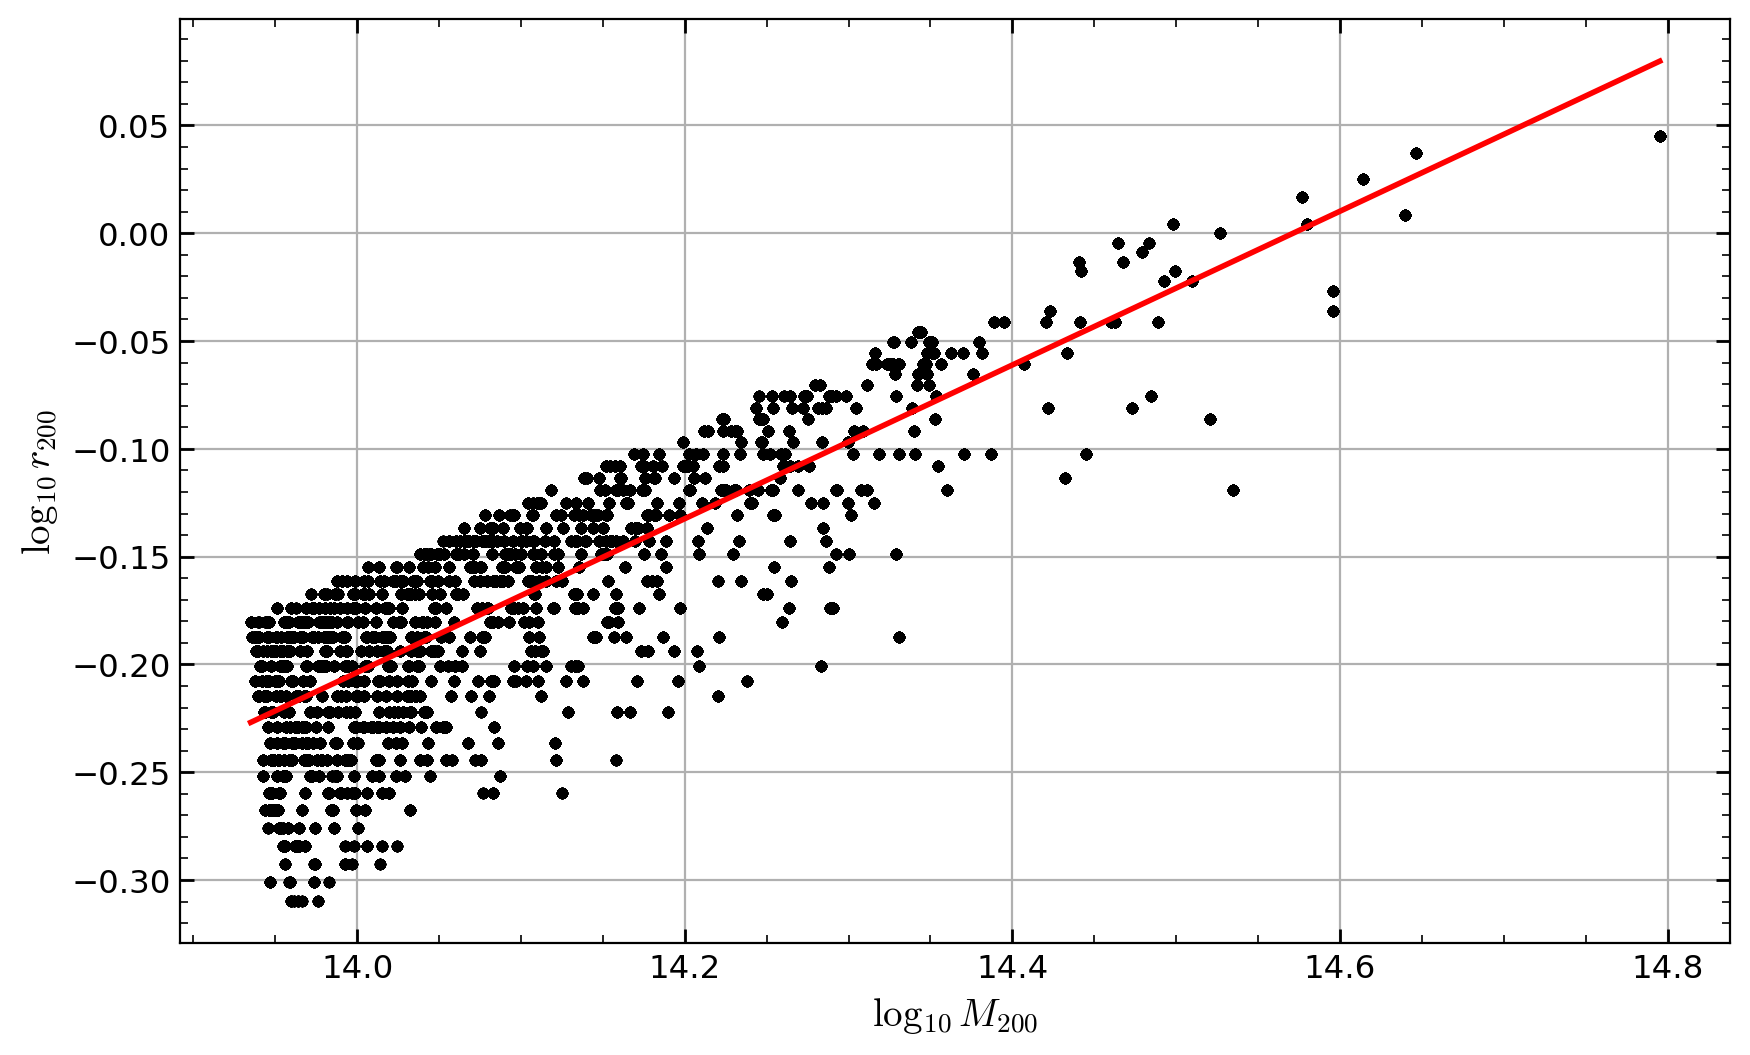

In [7]:
from sklearn.linear_model import LinearRegression

# fit r200-M200 relation
x = np.log10(data['M200'].values.astype(float))
y = np.log10(data['r200'].values.astype(float))

# fit
lr = LinearRegression().fit(x.reshape(-1,1), y)
print(f'log r200 = {lr.coef_[0]:.5f} log M200 + {lr.intercept_:.5f}')

x_ = np.linspace(x.min(), x.max(), 100)
y_ = lr.predict(x_.reshape(-1,1))

plt.plot(x, y, 'k.')
plt.plot(x_, y_, 'r-')
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel(r'$\log_{10} r_{200}$');

In [7]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [8]:
# plt.hist(np.unique(np.log10(data['M200'].values.astype('float64'))), 50);
data.columns

Index(['xtrue', 'ytrue', 'xami', 'yami', 'zobs', 'zwerr', 'Hmag', 'fHa',
       'Pmem', 'M', 'Comp', 'Cl_id', 'zctrue', 'zcphot', 'zwC50', 'zwC100',
       'zdC50', 'zdC100', 'M200', 'r200', 'vwC50', 'vwC100', 'vdC50',
       'vdC100'],
      dtype='object')

In [11]:
# TODO: cut on velocities?
# TODO: weight by Pamico?

def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    survey,
    comp,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # parse arguments
    if survey == 'wide':
        fHa_min = 2e-16
        zrange = (0.9, 1.8)
    elif survey == 'deep':
        fHa_min = 6e-17
        zrange = (0.4, 1.8)
    
    vname = f"v{survey[0]}C{int(comp*100)}"
    zname = f"z{survey[0]}C{int(comp*100)}"
    print(vname, zname)

    # mask out high velocity, low fHa, uncompleted, out-of-bounds data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)
    mask &= data['Comp'] < comp
    mask &= (data[zname] > zrange[0]) & (data[zname] < zrange[1])

    # get data
    data_names = ['xami','yami',vname,'Pmem']
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    np.random.seed(1952)
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values
    folds_batch = folddict[ids_batch].values

    # make train/test splits
    # fold = 0
    # mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    def save(name, arr):
        filepath = join(dirpath, name)
        print(f'saving {filepath}')
        np.save(filepath, arr)

    """
    # Old from when i saved for only one fold
    ## save galwise data
    map(save,
        ['x_train.npy', 'x_test.npy', 'theta_train.npy', 'theta_test.npy', 
         'ids_train.npy', 'ids_test.npy', 'folds.npy'],
        [gals[mask], gals[~mask], thetas[mask], thetas[~mask], 
         ids[mask], ids[~mask], folds]
    )

    ## save clusterwise data
    mask = folddict[ids_batch].values != fold
    map(save,
        ['ids_batch.npy', 'x_batch_train.npy', 'x_batch_test.npy',
         'x_sum_train.npy', 'x_sum_test.npy', 
         'theta_batch_train.npy', 'theta_batch_test.npy'],
        [ids_batch, x_batch[mask], x_batch[~mask],
         x_sum[mask], x_sum[~mask], 
         thetas_batch[mask], thetas_batch[~mask]]
    )
    """
    ## save galwise data
    list(map(save,
        ['x.npy', 'theta.npy', 'ids.npy', 'folds.npy'],
        [gals, thetas, ids, folds]
    ))

    ## save clusterwise data
    list(map(save,
        ['x_batch.npy', 'x_sum.npy', 'theta_batch.npy', 'ids_batch.npy', 'folds_batch.npy'],
        [x_batch, x_sum, thetas_batch, ids_batch, folds_batch]
    ))

    return gals, thetas, x_batch, x_sum, thetas_batch


In [12]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=0.5,
    dirpath='data/processed/AMICOwC50',
)
print(gals.shape)

vwC50 zwC50
saving data/processed/AMICOwC50/x.npy
saving data/processed/AMICOwC50/theta.npy
saving data/processed/AMICOwC50/ids.npy
saving data/processed/AMICOwC50/folds.npy
saving data/processed/AMICOwC50/x_batch.npy
saving data/processed/AMICOwC50/x_sum.npy
saving data/processed/AMICOwC50/theta_batch.npy
saving data/processed/AMICOwC50/ids_batch.npy
saving data/processed/AMICOwC50/folds_batch.npy
(1559, 4)


In [13]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=1,
    dirpath='data/processed/AMICOwC100',
)
print(gals.shape)

vwC100 zwC100
saving data/processed/AMICOwC100/x.npy
saving data/processed/AMICOwC100/theta.npy
saving data/processed/AMICOwC100/ids.npy
saving data/processed/AMICOwC100/folds.npy
saving data/processed/AMICOwC100/x_batch.npy
saving data/processed/AMICOwC100/x_sum.npy
saving data/processed/AMICOwC100/theta_batch.npy
saving data/processed/AMICOwC100/ids_batch.npy
saving data/processed/AMICOwC100/folds_batch.npy
(3062, 4)


In [14]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=0.5,
    dirpath='data/processed/AMICOdC50',
)
print(gals.shape)

vdC50 zdC50
saving data/processed/AMICOdC50/x.npy
saving data/processed/AMICOdC50/theta.npy
saving data/processed/AMICOdC50/ids.npy
saving data/processed/AMICOdC50/folds.npy
saving data/processed/AMICOdC50/x_batch.npy
saving data/processed/AMICOdC50/x_sum.npy
saving data/processed/AMICOdC50/theta_batch.npy
saving data/processed/AMICOdC50/ids_batch.npy
saving data/processed/AMICOdC50/folds_batch.npy
(23866, 4)


In [15]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=1,
    dirpath='data/processed/AMICOdC100',
)
print(gals.shape)

vdC100 zdC100
saving data/processed/AMICOdC100/x.npy
saving data/processed/AMICOdC100/theta.npy
saving data/processed/AMICOdC100/ids.npy
saving data/processed/AMICOdC100/folds.npy
saving data/processed/AMICOdC100/x_batch.npy
saving data/processed/AMICOdC100/x_sum.npy
saving data/processed/AMICOdC100/theta_batch.npy
saving data/processed/AMICOdC100/ids_batch.npy
saving data/processed/AMICOdC100/folds_batch.npy
(46217, 4)


13.940800364230586 0.37279120593766824


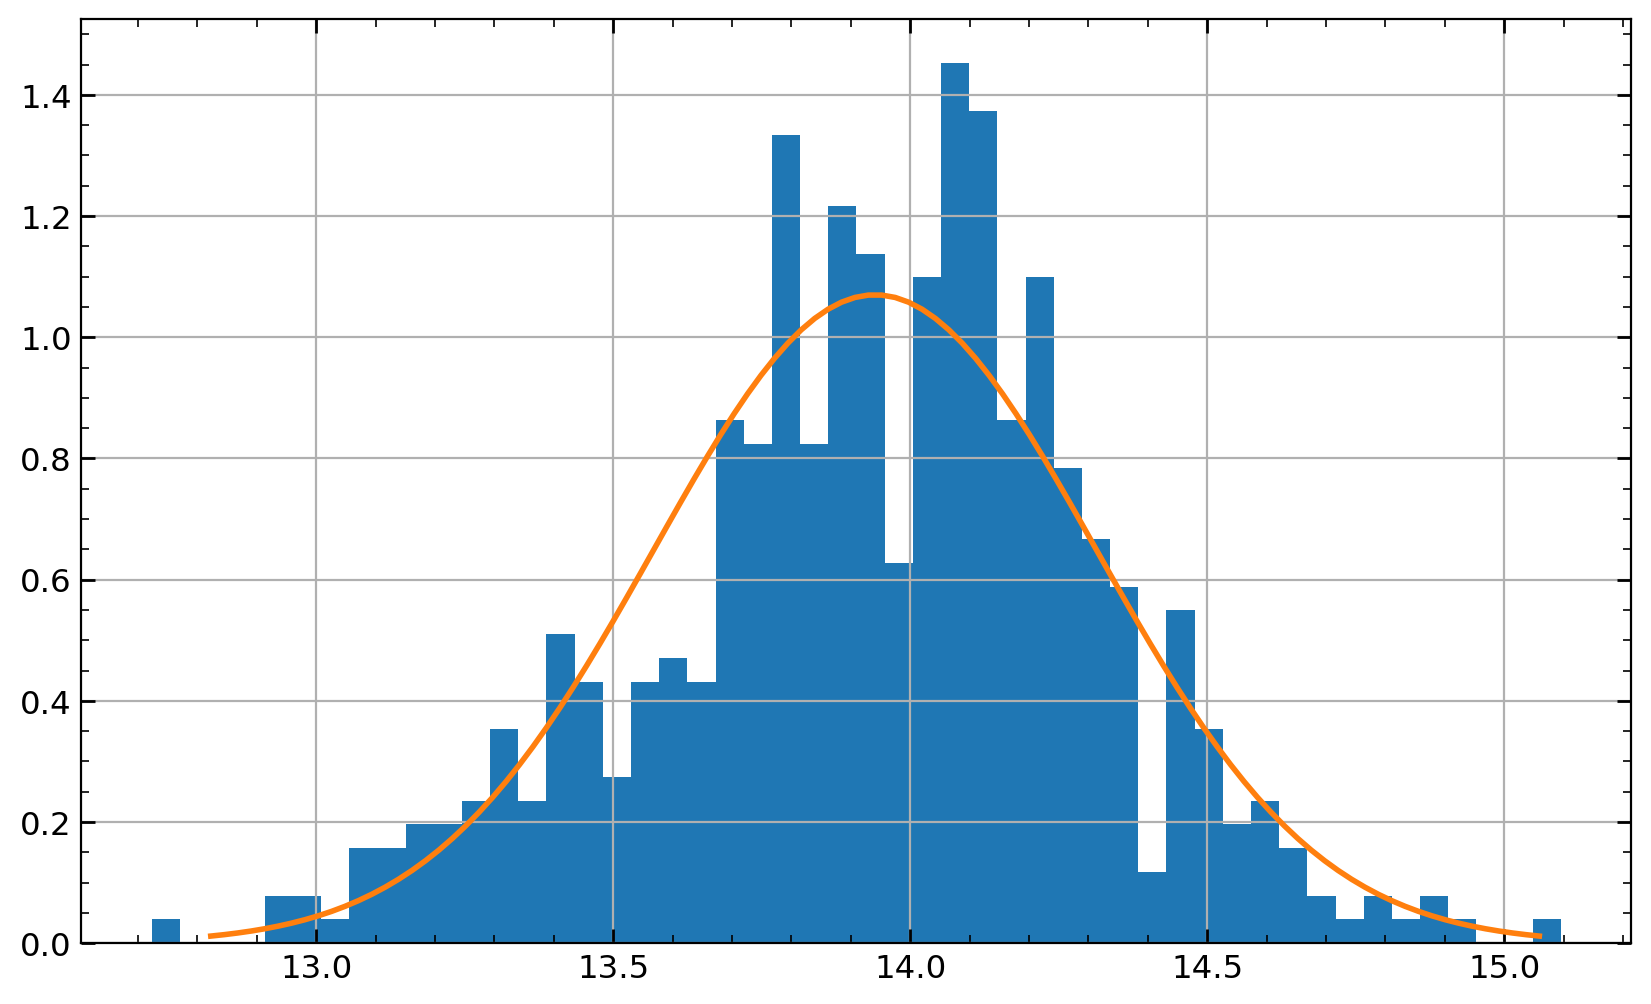

In [14]:
from scipy.stats import norm
mu, sig = np.mean(thetas_batch), np.std(thetas_batch)
plt.hist(thetas_batch, bins=50, density=True);
x_ = np.linspace(mu-3*sig, mu+3*sig, 100)
plt.plot(x_, norm.pdf(x_, mu, sig));
print(mu, sig)

# Andrea Flagship 2 + AMICO (19/04/2024)

In [18]:
data = pd.read_csv(
    'data/raw/deep_all_03042024.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

Ngal, Nclu = len(data), len(data.Cl_id.unique())
print(f'Ngal: {Ngal}, Nclu: {Nclu}')
print(f'Ngal/Nclu: {Ngal/Nclu:.2f}')

data.head()

/tmp/ipykernel_1362460/200964433.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


Ngal: 298693, Nclu: 2019
Ngal/Nclu: 147.94


,xtrue,ytrue,xami,yami,zobs,zwerr,Hmag,fHa,Pmem,M,...,zctrue,zcphot,zwC50,zwC100,zdC50,zdC100,M200,r200,rich,sig1d
0,0.230,-1.536,0.336,-1.464,0.408668,0.405,19.09,-15.564,0.028,0.0,...,0.478922,0.475,0.479621,0.479098,0.478362,0.478877,191460000000000.0,1.02,19.27,499.0
1,0.343,-1.265,0.449,-1.193,0.40883,0.4074,22.9,-16.258,0.092,0.0,...,0.478922,0.475,0.479621,0.479098,0.478362,0.478877,191460000000000.0,1.02,19.27,499.0
2,0.201,-1.787,0.308,-1.715,0.40966,0.4077,19.89,-16.026,0.055,0.0,...,0.478922,0.475,0.479621,0.479098,0.478362,0.478877,191460000000000.0,1.02,19.27,499.0
3,-0.048,-0.423,0.059,-0.351,0.408646,0.4078,21.49,-16.055,0.189,0.0,...,0.478922,0.475,0.479621,0.479098,0.478362,0.478877,191460000000000.0,1.02,19.27,499.0
4,-0.242,-2.192,-0.135,-2.12,0.410411,0.4104,21.96,-16.149,0.022,0.0,...,0.478922,0.475,0.479621,0.479098,0.478362,0.478877,191460000000000.0,1.02,19.27,499.0


log r200 = 0.37093 log M200 + -5.35656


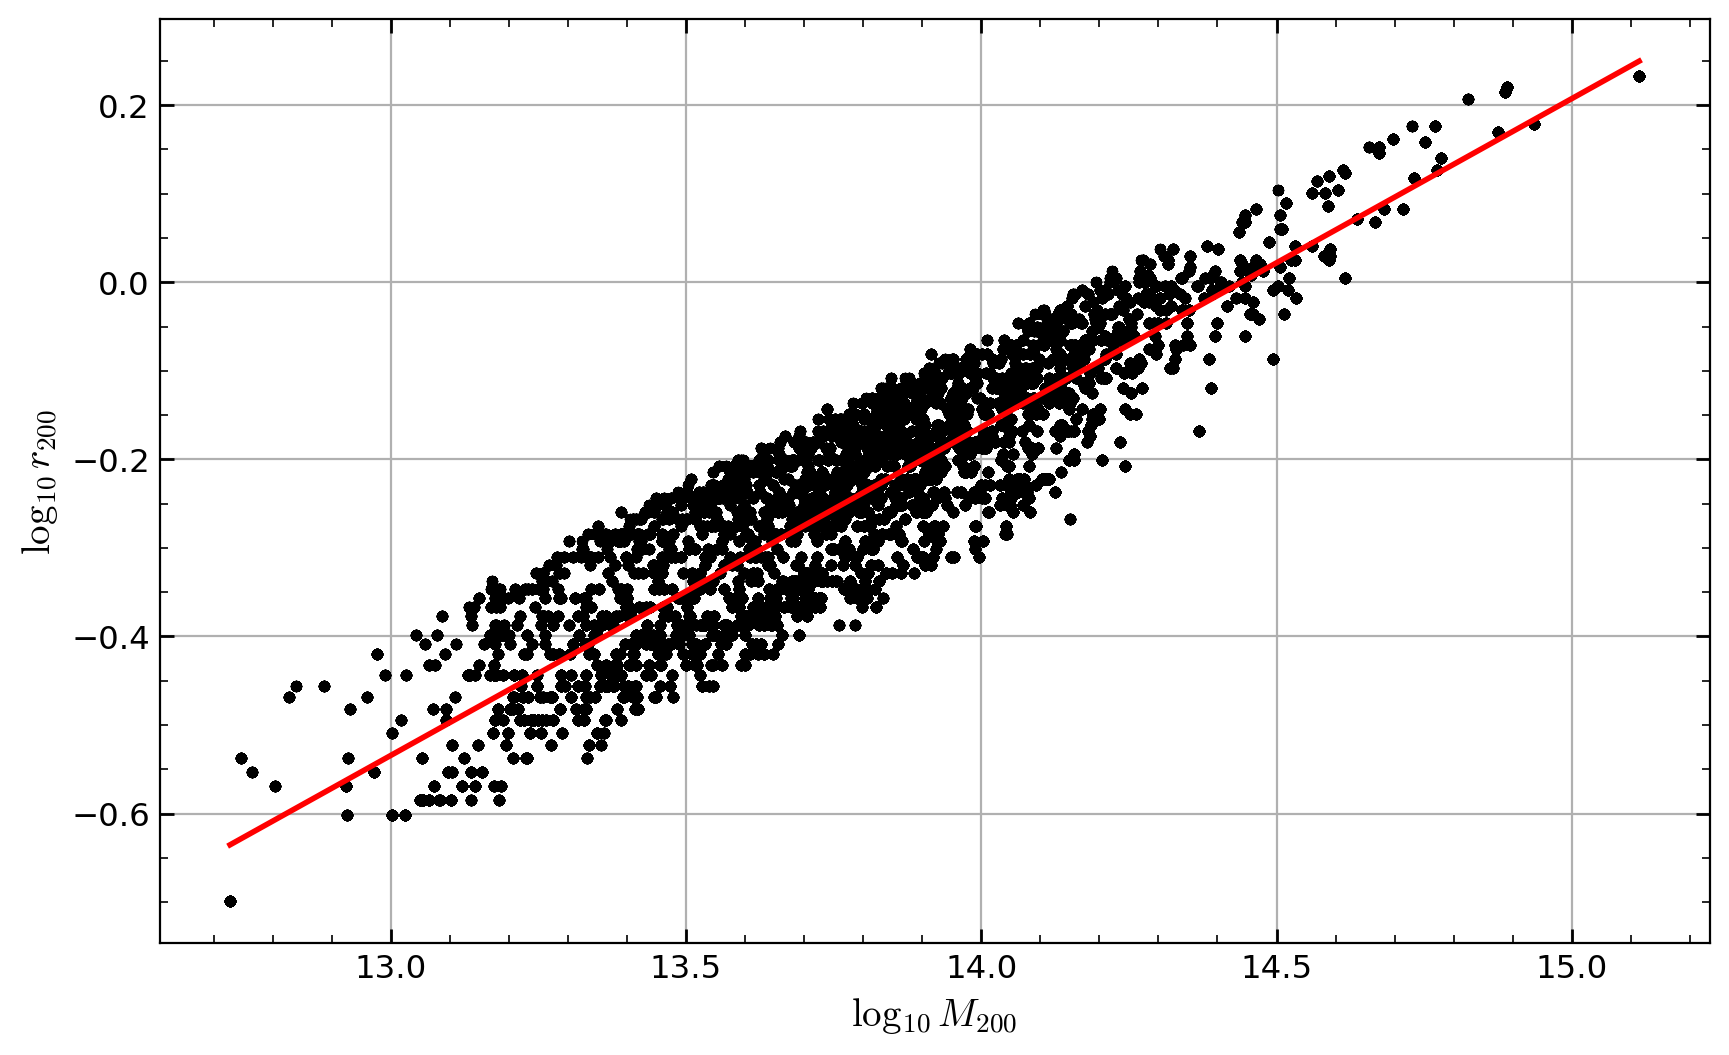

In [19]:
from sklearn.linear_model import LinearRegression

# fit r200-M200 relation
x = np.log10(data['M200'].values.astype(float))
y = np.log10(data['r200'].values.astype(float))

# fit
lr = LinearRegression().fit(x.reshape(-1,1), y)
print(f'log r200 = {lr.coef_[0]:.5f} log M200 + {lr.intercept_:.5f}')

x_ = np.linspace(x.min(), x.max(), 100)
y_ = lr.predict(x_.reshape(-1,1))

plt.plot(x, y, 'k.')
plt.plot(x_, y_, 'r-')
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel(r'$\log_{10} r_{200}$');

In [20]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [21]:
# plt.hist(np.unique(np.log10(data['M200'].values.astype('float64'))), 50);
data.columns

Index(['xtrue', 'ytrue', 'xami', 'yami', 'zobs', 'zwerr', 'Hmag', 'fHa',
       'Pmem', 'M', 'Comp', 'Cl_id', 'zctrue', 'zcphot', 'zwC50', 'zwC100',
       'zdC50', 'zdC100', 'M200', 'r200', 'rich', 'sig1d', 'vwC50', 'vwC100',
       'vdC50', 'vdC100'],
      dtype='object')

In [22]:
# TODO: cut on velocities?
# TODO: weight by Pamico?

def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    survey,
    comp,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # parse arguments
    if survey == 'wide':
        fHa_min = 2e-16
        zrange = (0.9, 1.8)
    elif survey == 'deep':
        fHa_min = 6e-17
        zrange = (0.4, 1.8)
    
    vname = f"v{survey[0]}C{int(comp*100)}"
    zname = f"z{survey[0]}C{int(comp*100)}"
    print(vname, zname)

    # mask out high velocity, low fHa, uncompleted, out-of-bounds data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)
    mask &= data['Comp'] < comp
    mask &= (data[zname] > zrange[0]) & (data[zname] < zrange[1])

    # get data
    data_names = ['xami','yami',vname,'Pmem']
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    np.random.seed(1952)
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values
    folds_batch = folddict[ids_batch].values

    # make train/test splits
    # fold = 0
    # mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    def save(name, arr):
        filepath = join(dirpath, name)
        print(f'saving {filepath}')
        np.save(filepath, arr)

    """
    # Old from when i saved for only one fold
    ## save galwise data
    map(save,
        ['x_train.npy', 'x_test.npy', 'theta_train.npy', 'theta_test.npy', 
         'ids_train.npy', 'ids_test.npy', 'folds.npy'],
        [gals[mask], gals[~mask], thetas[mask], thetas[~mask], 
         ids[mask], ids[~mask], folds]
    )

    ## save clusterwise data
    mask = folddict[ids_batch].values != fold
    map(save,
        ['ids_batch.npy', 'x_batch_train.npy', 'x_batch_test.npy',
         'x_sum_train.npy', 'x_sum_test.npy', 
         'theta_batch_train.npy', 'theta_batch_test.npy'],
        [ids_batch, x_batch[mask], x_batch[~mask],
         x_sum[mask], x_sum[~mask], 
         thetas_batch[mask], thetas_batch[~mask]]
    )
    """
    ## save galwise data
    list(map(save,
        ['x.npy', 'theta.npy', 'ids.npy', 'folds.npy'],
        [gals, thetas, ids, folds]
    ))

    ## save clusterwise data
    list(map(save,
        ['x_batch.npy', 'x_sum.npy', 'theta_batch.npy', 'ids_batch.npy', 'folds_batch.npy'],
        [x_batch, x_sum, thetas_batch, ids_batch, folds_batch]
    ))

    return gals, thetas, x_batch, x_sum, thetas_batch


In [23]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=0.5,
    dirpath='data/processed/APR24wC50',
)
print(gals.shape)

vwC50 zwC50
saving data/processed/APR24wC50/x.npy
saving data/processed/APR24wC50/theta.npy
saving data/processed/APR24wC50/ids.npy
saving data/processed/APR24wC50/folds.npy
saving data/processed/APR24wC50/x_batch.npy
saving data/processed/APR24wC50/x_sum.npy
saving data/processed/APR24wC50/theta_batch.npy
saving data/processed/APR24wC50/ids_batch.npy
saving data/processed/APR24wC50/folds_batch.npy
(5318, 4)


In [24]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=1,
    dirpath='data/processed/APR24wC100',
)
print(gals.shape)

vwC100 zwC100
saving data/processed/APR24wC100/x.npy
saving data/processed/APR24wC100/theta.npy
saving data/processed/APR24wC100/ids.npy
saving data/processed/APR24wC100/folds.npy
saving data/processed/APR24wC100/x_batch.npy
saving data/processed/APR24wC100/x_sum.npy
saving data/processed/APR24wC100/theta_batch.npy
saving data/processed/APR24wC100/ids_batch.npy
saving data/processed/APR24wC100/folds_batch.npy
(10415, 4)


In [25]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=0.5,
    dirpath='data/processed/APR24dC50',
)
print(gals.shape)

vdC50 zdC50
saving data/processed/APR24dC50/x.npy
saving data/processed/APR24dC50/theta.npy
saving data/processed/APR24dC50/ids.npy
saving data/processed/APR24dC50/folds.npy
saving data/processed/APR24dC50/x_batch.npy
saving data/processed/APR24dC50/x_sum.npy
saving data/processed/APR24dC50/theta_batch.npy
saving data/processed/APR24dC50/ids_batch.npy
saving data/processed/APR24dC50/folds_batch.npy
(72861, 4)


In [26]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=1,
    dirpath='data/processed/APR24dC100',
)
print(gals.shape)

vdC100 zdC100
saving data/processed/APR24dC100/x.npy
saving data/processed/APR24dC100/theta.npy
saving data/processed/APR24dC100/ids.npy
saving data/processed/APR24dC100/folds.npy
saving data/processed/APR24dC100/x_batch.npy
saving data/processed/APR24dC100/x_sum.npy
saving data/processed/APR24dC100/theta_batch.npy
saving data/processed/APR24dC100/ids_batch.npy
saving data/processed/APR24dC100/folds_batch.npy
(141357, 4)


13.776200370712232 0.34794719493068393


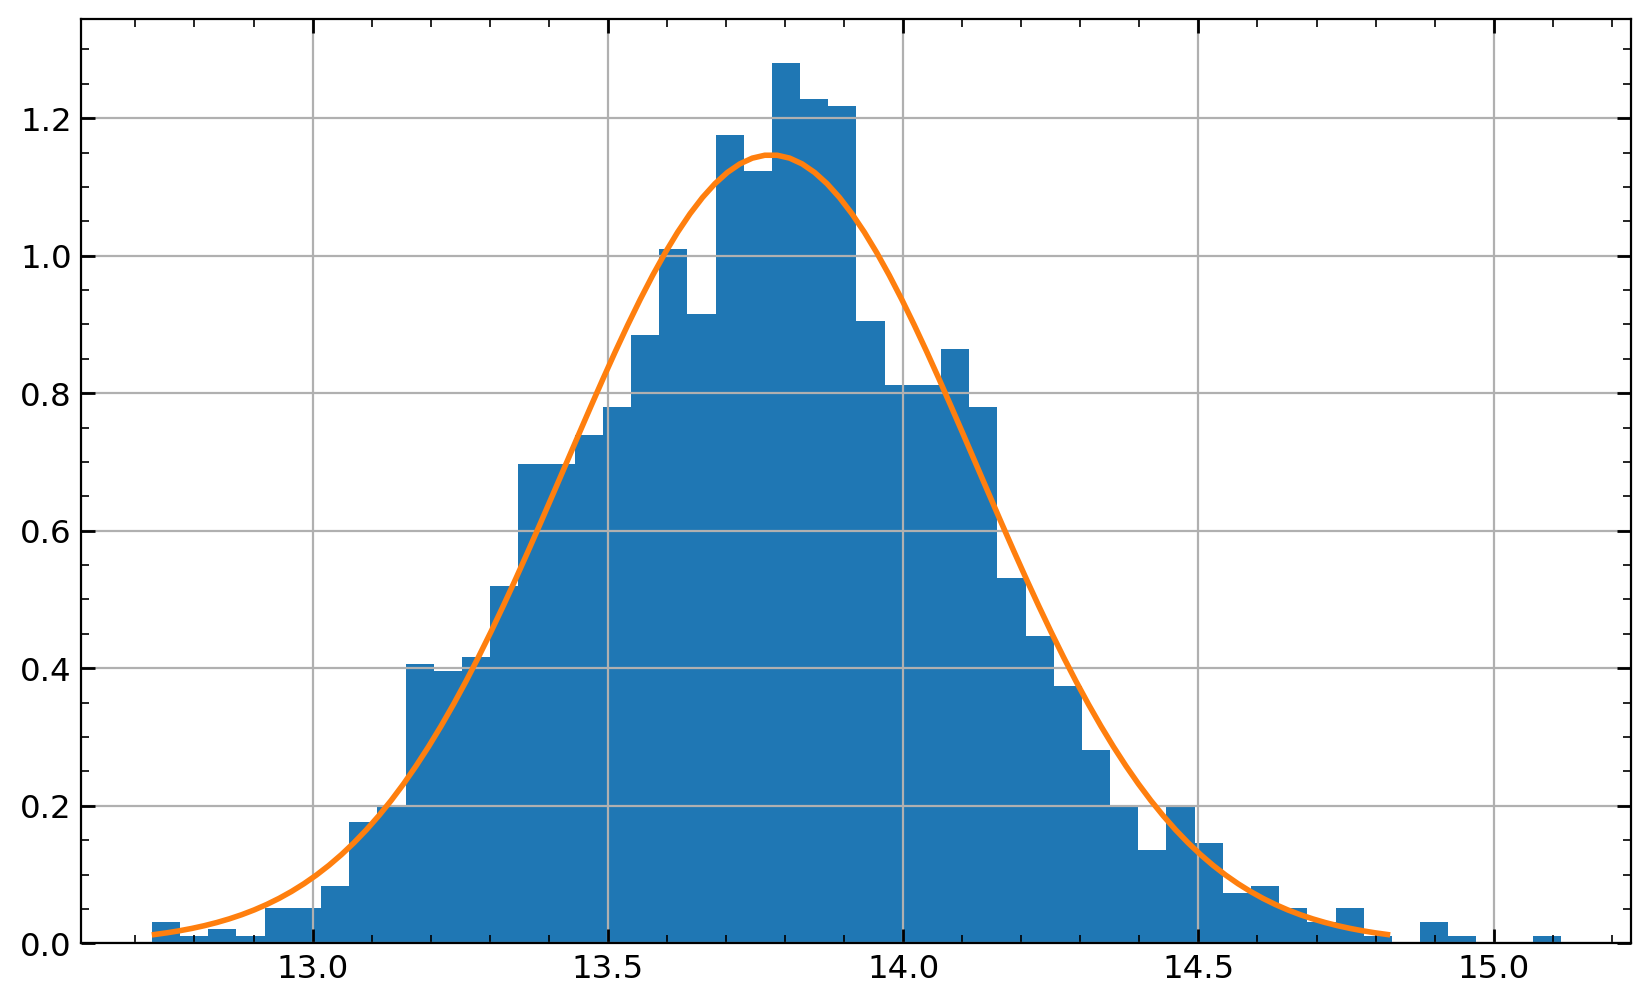

In [27]:
from scipy.stats import norm
mu, sig = np.mean(thetas_batch), np.std(thetas_batch)
plt.hist(thetas_batch, bins=50, density=True);
x_ = np.linspace(mu-3*sig, mu+3*sig, 100)
plt.plot(x_, norm.pdf(x_, mu, sig));
print(mu, sig)